In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

sys.path.append(Path().resolve())
sys.path.append(os.path.join(Path().resolve(), 'DigiLeTs/scripts'))

In [2]:
from data import read_original_data

In [3]:
from env import DrawingEnv_Moc1

In [4]:
def fill_traj(target_position, initial_position, norm, z_pos=0):
    positions = [initial_position]
    d_pos = target_position[:2] - positions[-1][:2]
    while np.linalg.norm(d_pos) > norm:
        pos = positions[-1][:2] + (d_pos / np.linalg.norm(d_pos) * norm)
        positions.append(np.hstack([pos, z_pos]))
        d_pos = target_position[:2] - positions[-1][:2]
    return positions

def get_trajectory(instance, initial_position):
    # initial_position = np.array([0.8, 0.2, 0])
    norm = np.linalg.norm(instance[1:,:2]-instance[:-1,:2], axis=-1)
    norm_mean = norm[norm>0].mean()
    trajectory = fill_traj(target_position=instance[0], initial_position=initial_position, norm=norm_mean)
    
    for i in range(0, len(instance) - 1):
        if (instance[i][5] == 0 and instance[i+1][5] == 0) and (instance[i+1][3] == 0):
            position = [np.array((instance[i+1][0], instance[i+1][1], 1))]
        else:
            position = fill_traj(target_position=instance[i+1], initial_position=trajectory[-1], norm=norm_mean)
        trajectory += position

    trajectory += fill_traj(target_position=initial_position, initial_position=trajectory[-1], norm=norm_mean)
    trajectory = np.array(trajectory)
    return trajectory

In [5]:
# import cv2
# import copy

# def get_image_sequence(instance, size=256, line_width=3, threshold=None):
#     initial_position=np.array((0.8, 0.8, 0))
#     params = dict(size=256,
#                 line_color=(50,50,50),
#                 line_width=3,
#                 digit_area = [30,36,158,164],
#                 initial_position=initial_position,
#                 max_step=2e2,
#                 )
#     instance[:,1] = 1-instance[:,1]
#     trajectory = get_trajectory(instance=instance, initial_position=initial_position)
    
    
#     env = DrawingEnv_Moc1(params)
#     observation = env.init()
#     images = [observation["image"]]
#     mask = [observation["mask"]]
#     actions = []
#     positions = [observation["position"]]
#     for t in range(0, len(trajectory) - 1):
#         observation, reward, done, info = env.step(trajectory[t])
#         images.append(observation["image"])
#         positions.append(observation["position"])
#         mask.append(observation["mask"])
#         action = trajectory[t+1][:2]-trajectory[t][:2]
#         actions.append(action)

#     images = np.array(images).astype(np.uint8)
#     mask = np.array(mask).astype(np.uint8)
#     positions = np.array(positions)
#     observations = dict(image=images,
#                         mask=mask,
#                         position=positions,
#                     )
#     actions = np.array(actions)
#     rewards = np.zeros(len(actions))
#     dones = np.zeros(len(actions))
#     dones[-1] = 1
#     return observations, actions, rewards, dones


In [6]:
import cv2
import copy

def get_image_sequence(instance, size=256, line_width=3, threshold=None):
    initial_position=np.array((0.8, 0.8, 0))
    params = dict(size=256,
                line_color=(50,50,50),
                line_width=3,
                digit_area = [30,36,158,164],
                initial_position=initial_position,
                max_step=2e2,
                )
    instance[:,1] = 1-instance[:,1]
    trajectory = get_trajectory(instance=instance, initial_position=initial_position)
    
    observations = dict()
    env = DrawingEnv_Moc1(params)
    observation = env.init()
    for key in observation.keys():
        observations[key] = [observation[key]]
    actions = []
    for t in range(0, len(trajectory) - 1):
        observation, reward, done, info = env.step(trajectory[t])
        for key in observation.keys():
            observations[key].append(observation[key])
        action = trajectory[t+1][:2]-trajectory[t][:2]
        actions.append(action)

    for key in observations.keys():
        if ("image" in key) or ("mask" == key):
            observations[key] = np.array(observations[key]).astype(np.uint8)
        else:
            observations[key] = np.array(observations[key])
    actions = np.array(actions)
    rewards = np.zeros(len(actions))
    dones = np.zeros(len(actions))
    dones[-1] = 1
    return observations, actions, rewards, dones


In [7]:
import glob
data_dir = "DigiLeTs/data/preprocessed/complete"
filenames = glob.glob(os.path.join(data_dir, '*_preprocessed'))

In [8]:
import os
for idx in range(len(filenames)):
    filename = filenames[idx]
    basename = os.path.basename(filename)
    participant = read_original_data(filename)
    if idx < 70:
        save_folder = "dataset/Drawing/realistic/train"
    else:
        save_folder = "dataset/Drawing/realistic/validation"
    for s, symbol in enumerate(participant["trajectories"]):
        if s > 9:
            # 数字以外は省略
            break
        for i, _instance in enumerate(symbol):
            
            instance = _instance[:participant["lengths"][s, i]]
            observations, actions, rewards, dones = get_image_sequence(instance, size=64, line_width=3)
            dataset = dict()
            for key in observations.keys():
                dataset[key] = observations[key]
            dataset["action"] = actions
            dataset["reward"] = rewards
            dataset["done"] = dones
            dataset["digit"] = np.ones_like(dones) * s
            
        break
    break


Reading from: DigiLeTs/data/preprocessed/complete/002-f-22-right_2019-06-05-12-21-29_preprocessed


In [10]:
dataset.keys()

dict_keys(['image', 'image_digit', 'image_body', 'image_residual', 'mask', 'position', 'action', 'reward', 'done', 'digit'])

In [11]:
len(dataset["image"])

134

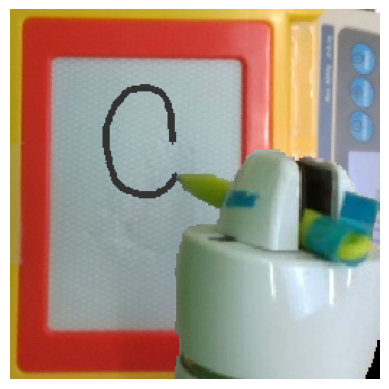

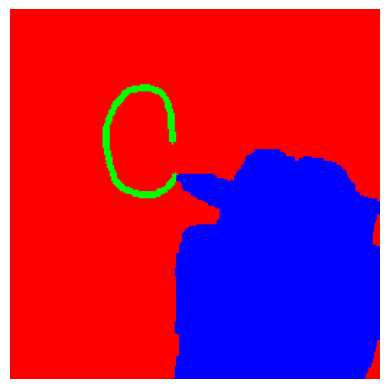

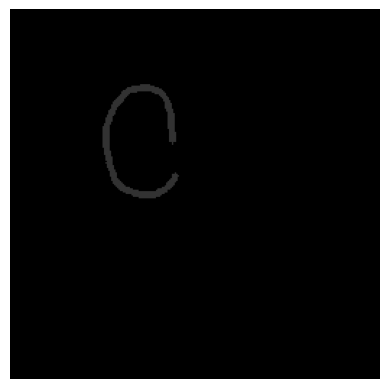

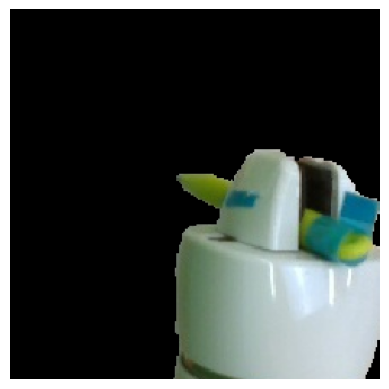

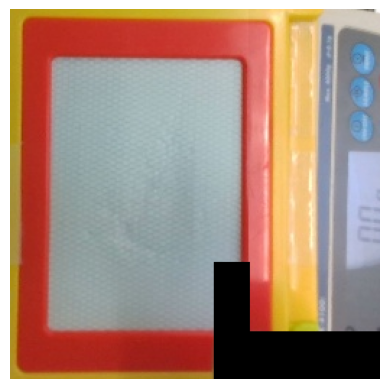

In [17]:
save_folder = "figs"
t = 70
t = 93
plt.imshow(dataset["image"][t])
plt.axis("off")
plt.savefig(f"{save_folder}/image.png")
plt.show()
plt.imshow(dataset["mask"][t]*255)
plt.axis("off")
plt.savefig(f"{save_folder}/mask.png")
plt.show()
plt.imshow(dataset["image_digit"][t])
plt.axis("off")
plt.savefig(f"{save_folder}/image_digit.png")
plt.show()
plt.imshow(dataset["image_body"][t])
plt.axis("off")
plt.savefig(f"{save_folder}/image_body.png")
plt.show()
plt.imshow(dataset["image_residual"][t])
plt.axis("off")
plt.savefig(f"{save_folder}/image_residual.png")
plt.show()

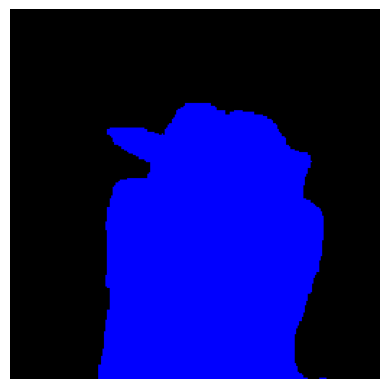

In [ ]:
mask_body = dataset["mask"][t]*255
mask_body[:,:,0] = 0
mask_body[:,:,1] = 0
plt.imshow(mask_body)
plt.axis("off")
plt.savefig(f"{save_folder}/mask_body.png")


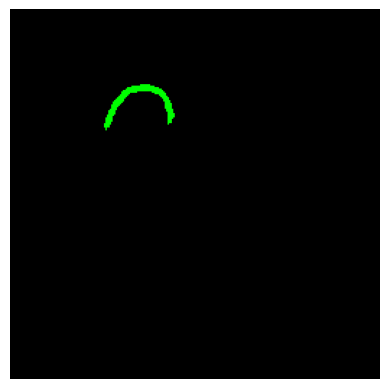

In [ ]:
mask_digit = dataset["mask"][t]*255
mask_digit[:,:,0] = 0
mask_digit[:,:,2] = 0
plt.imshow(mask_digit)
plt.axis("off")
plt.savefig(f"{save_folder}/mask_digit.png")


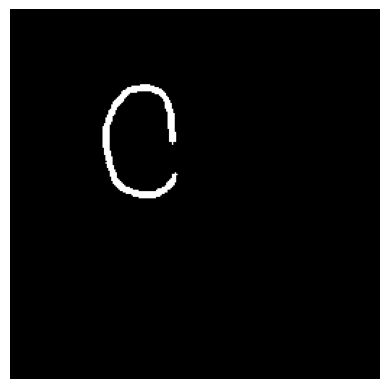

In [18]:
mask_digit = dataset["mask"][t]*255
mask_digit[:,:,0] = mask_digit[:,:,1]
mask_digit[:,:,2] = mask_digit[:,:,1]
plt.imshow(mask_digit)
plt.axis("off")
plt.savefig(f"{save_folder}/mask_digit_white.png")


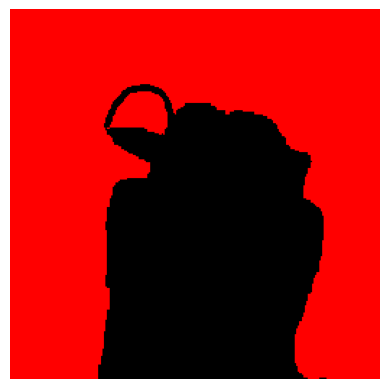

In [ ]:
mask_residual = dataset["mask"][t]*255
mask_residual[:,:,1] = 0
mask_residual[:,:,2] = 0
plt.imshow(mask_residual)
plt.axis("off")
plt.savefig(f"{save_folder}/mask_residual.png")


In [ ]:
digit = np.ones_like(dones).astype(np.int16) * s
digit

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0], dtype=int16)

In [ ]:
i = np.identity(10, dtype=np.float32)[digit]
i

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)